# Name: Thanh Quyen, Nguyen

# Topic: 
Volatility spillovers in commodity markets: A large t-vector autoregressive approach

## package and functions

In [1]:
import pandas
import datetime
import numpy
import matplotlib.pyplot as plt
import scipy.linalg
from scipy.optimize import minimize
from functools import reduce
import pickle
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [2]:
def get_df(tckr_list=['WTI', 'GASOLINE', 'HH', 'ETHANOL', 'CORN', 'WHEAT', 'SOYBEAN', 'SUGAR', 'COTTON', 'COFFE']):#, start_date, end_date):
    """get the whole log data for analysis and modelling"""
    df = pandas.read_csv(r'C:\Users\DELL\Desktop\FinEco\data.csv')
    dfs = []
    for tckr in tckr_list:
        data = df[(df['REGION'] == tckr)][['DATE', 'VOL']].sort_values(by='DATE', ascending=True)
        data.rename(columns={'VOL':tckr}, inplace=True)
        dfs.append(data)
    data = reduce(lambda left, right: pandas.merge(left, right, on='DATE'), dfs)
    data.reset_index(inplace=True, drop=True)
    data.DATE = pandas.to_datetime(data.DATE)
    non_zero_data = pandas.DataFrame(numpy.where(data.iloc[:,1:] > 0, data.iloc[:,1:], 10 ** (-10)))
    non_zero_data.columns = tckr_list
    log_data = pandas.DataFrame(data.DATE)
    log_data = pandas.concat([log_data, numpy.log(non_zero_data)], axis = 1)
    return log_data


def get_ts(start_date, estimation_length, no_lag):
    """get time series with specific start of the series, and number of lag for model to ensure estimation length meets requirements"""
    data = get_df()
    Y = data[data.DATE >= start_date]
    Y = Y.iloc[:estimation_length + no_lag,:]
    Y.reset_index(drop=True, inplace=True)
    return Y


def get_input(start_date, estimation_length, no_lag):
    """get X, Y"""
    Y = get_ts(start_date, estimation_length, no_lag)
    index = Y.DATE
    columns = Y.columns[1:]
    Y.drop('DATE', axis = 1, inplace=True)
    #Y = pandas.DataFrame(numpy.where(Y > 0, Y, 10 ** (-10)))
    Y.columns = columns
    Y.index = index
    #columns = Y.columns
    #X = pandas.DataFrame(numpy.ones(Y.shape[0]))
    #X.index = Y.index
    X = pandas.DataFrame()
    X_cols = [] #['INTERCEPT']
    for l in range(1, no_lag + 1):
        X = pandas.concat([X, Y.iloc[:,:10].shift(l)], axis=1)
        col_names = [col + '_L' + str(l) for col in columns]
        X_cols += col_names
        X.columns = X_cols
    X['INTERCEPT'] = numpy.ones(X.shape[0])
    X.dropna(inplace=True)
    Y = Y[Y.index.isin(X.index)]
    return X, Y

def get_predictors(ts, pred_start, no_lag):
    """get X for forecasting"""
    if ts is None:
        #ts = get_ts(pred_start-datetime.timedelta(days=no_lag), 0, no_lag+1).iloc[:, 1:]
        ts = get_df()
        ts = ts[ts['DATE'] <= pred_start]
        ts = ts.iloc[-no_lag-1:,1:]
    columns = ts.columns
    #ts.drop('DATE', axis=1, inplace=True)
    #X = pandas.DataFrame(numpy.ones(no_lag))
    X = pandas.DataFrame()
    X_cols = []#['INTERCEPT']
    for l in range(1, no_lag + 1):
        X = pandas.concat([X, ts.iloc[:, :10].shift(l)], axis=1)
        col_names = [col + '_L' + str(l) for col in columns]
        X_cols += col_names
        X.columns = X_cols
    X['INTERCEPT'] = numpy.ones(X.shape[0])
    X = X.iloc[-1:,:]
    return X, ts.iloc[:-1,:]

def pickle_write(file_name, object):
    with open(file_name, 'wb') as handle:
        pickle.dump(object, handle)

def pickle_load(file_name = 'forecast_error_h5.pickle'):
    with open(file_name, 'rb') as handle:
        error = pickle.load(handle)
    return error

class Lasso:
    """define loss function, optimize process and algorithms for Gaussian and t-Lasso estimation"""

    def _pred(self,X,w):
        """get y_hat (fitted value) or prediction"""
        return numpy.dot(X,w)

    """def LossLasso(self,weights,X,y,alpha):
        w = numpy.reshape(weights, (-1, y.shape[0]))
        yp = self._pred(X,w)
        #loss = numpy.linalg.norm(y - yp.transpose())**2 + alpha * numpy.sum(abs(w))
        loss = numpy.trace(numpy.dot(y-yp.transpose(), (y-yp.transpose()).transpose())) + alpha * numpy.sum(abs(w))
        return loss

    def fit(self,X,y,alpha=0.0):
        #initw = numpy.random.rand(X.shape[1]) #initial weights
        initw = numpy.zeros((X.shape[1], y.shape[0]))
        res = minimize(self.LossLasso,
                    initw,
                    args=(X,y,alpha),
                    method='Powell')
        return res"""

    def tLasso_weightedData(self, *args):
        """get weighted X, Y for t-lasso"""
        dg_freedom = args[0]
        dimension = args[1]
        omega = args[2]
        resi = args[3]
        tau = (dg_freedom + dimension)/(dg_freedom + numpy.dot(numpy.dot(resi, omega), resi.transpose()))
        T = numpy.diag(numpy.diag(tau))
        X = numpy.dot(scipy.linalg.sqrtm(T), args[4].iloc[:, :-1])
        Y = numpy.dot(scipy.linalg.sqrtm(T), args[5])
        return X, Y
    
    def GaussLasso(self, beta, X, y, Omega, alpha, gamma):
        """Gaussian Lasso loss"""
        #initOmega = numpy.ones(y.shape[1], y.shape[1])
        #initbeta = numpy.zeros((X.shape[1], Y.shape[1]))
        b = numpy.reshape(beta, (-1, y.shape[0]))
        om = numpy.reshape(Omega, (-1, y.shape[0]))
        yp = self._pred(X, b)
        loss = numpy.trace(numpy.dot(numpy.dot((y - yp.transpose()).transpose(), om),(y - yp.transpose())))/(2*X.shape[0]) - 0.5 * numpy.log(numpy.linalg.det(om)) + \
               alpha * numpy.sum(abs(b)) + gamma * sum([abs(om[i][j]) for i in range(y.shape[0]) for j in range(10) if i!=j])
        #print(loss)
        return loss

    def fit_GaussLasso(self,X,y,param,omega,alpha=0.0,gamma=0,method='CG'):
        #initw = numpy.random.rand(X.shape[1]) #initial weights
        initb =numpy.reshape(param, (-1, y.shape[0]))
        res = minimize(self.GaussLasso,
                    initb,
                    args=(X,y,omega,alpha,gamma),
                    method=method)
        return res

    def run_GaussianLasso(self, *args):
        X = args[0]
        y = args[1]
        param = args[2]
        alpha = args[3]
        omega = args[4]
        gamma = args[5]
        method = args[6]
        fit = self.fit_GaussLasso(X=X, y=y, param=param, alpha=alpha, omega=omega, gamma=gamma, method=method)
        param = numpy.reshape(fit.x, (-1, y.shape[0]))
        y_fitted = self._pred(X, param)
        residual = y - y_fitted.transpose()
        return fit, param, residual.transpose()

    def bic_lambda(self, X, y, omega, beta_hat):
        """BIC for model selection"""
        b = numpy.reshape(beta_hat, (-1, y.shape[0]))
        yp = self._pred(X, b)
        bic = -numpy.trace(numpy.dot(numpy.dot((y - yp.transpose()).transpose(), omega),(y - yp.transpose())))/X.shape[0] + numpy.log(X.shape[0])* numpy.count_nonzero(b)

        return bic

    def bic_gamma(self, X, y, omega, beta_hat, J):
        """BIC for model selection"""
        b = numpy.reshape(beta_hat, (-1, y.shape[0]))
        yp = self._pred(X, b)
        bic = -numpy.trace(numpy.dot(numpy.dot((y - yp.transpose()).transpose(), omega), (y - yp.transpose())))/X.shape[0] + numpy.log(X.shape[0])* (numpy.count_nonzero(omega) - J)/2
        return bic

class volatilities_spillover:

    def get_ts_vo_spillover(self, error):
        """error is the dict of forecast error"""
        for ii in range(len(error['ERROR'])):
            error['ERROR'][ii] = error['ERROR'][ii].iloc[::-1].reset_index(drop=True)

        Y_vs = pandas.DataFrame([error['ERROR'][ii].iloc[0, :] for ii in range(len(error['ERROR']))])
        tckr_list = ['WTI', 'GASOLINE', 'HH', 'ETHANOL', 'CORN', 'WHEAT', 'SOYBEAN', 'SUGAR', 'COTTON', 'COFFE']
        X_vs_columns = [tckr + f'_H{i}' for i in range(5, 0, -1) for tckr in tckr_list]
        X_vs = pandas.DataFrame()
        for ii in range(len(error['ERROR'])):
            Xvs_temp = pandas.DataFrame()
            X_temp = error['ERROR'][ii].stack()
            for iii in range(5):
                Xvs_temp = pandas.concat([Xvs_temp, X_temp[iii]])
            Xvs_temp = Xvs_temp.transpose()
            Xvs_temp.columns = X_vs_columns
            X_vs = pandas.concat([X_vs, Xvs_temp], axis=0)

        return X_vs, Y_vs

    def get_theta_ma(self, error, tckr_list = ['WTI', 'GASOLINE', 'HH', 'ETHANOL', 'CORN', 'WHEAT', 'SOYBEAN', 'SUGAR', 'COTTON', 'COFFE']):
        """get theta_hat for volatility spillover computation"""
        X_vs, Y_vs = self.get_ts_vo_spillover(error)
        theta = pandas.DataFrame(numpy.dot(numpy.linalg.inv(numpy.dot(X_vs.transpose(), X_vs)),
                                           numpy.dot(X_vs.transpose(), Y_vs))).transpose()
        theta.index = tckr_list
        theta.columns = X_vs.columns

        return theta
    
    def variance_by_kcom(self, j_com, k_com, theta, sigma_hat, h = 5):
        # j!=k, j_vector is the selection vector of length J with unity entry as its kth element and zeros elsewhere
        j_vec = numpy.zeros(10)
        j_vec[j_com] = 1
        k_vec = numpy.zeros(10)
        k_vec[k_com] = 1

        # nominator
        sigma_kk = sigma_hat.iloc[k_com,k_com]
        nominator = 0
        denominator  = 0
        for ii in range(1, 6):
            theta_p = theta.iloc[:,(ii-1)*10: ii*10]
            nominator += numpy.dot(numpy.dot(numpy.dot(j_vec, theta_p),sigma_hat), k_vec)**2
            denominator += numpy.dot(numpy.dot(numpy.dot(numpy.dot(j_vec, theta_p), sigma_hat), theta_p.transpose()), j_vec)
            
        w_jk = nominator / (sigma_kk *denominator)
        return w_jk

    def vol_spillover(self, j_com, k_com, theta, sigma_hat, com_list=numpy.arange(0, 10)):
    
        w_array = []
        for k in com_list:
            w_array.append(self.variance_by_kcom(j_com, k, theta, sigma_hat))

        w_jk = self.variance_by_kcom(j_com, k_com,theta, sigma_hat)

        return 100*w_jk/numpy.sum(w_array)

def main(start_date, estimation_length, no_lag, alpha, gamma, lasso_method, initparam = None):
    result_dict = {}
    deg_freedom = 10
    J = 10
    method = 'Powell'
    X_init, Y_init = get_input(start_date, estimation_length, no_lag) #include intercept
    clf = Lasso()
    omega = numpy.eye(Y_init.shape[1])
    if initparam is None:
        initparam = numpy.zeros((X_init.shape[1], Y_init.shape[1]))
    initresi = (Y_init.transpose() - clf._pred(X_init, initparam).transpose()).transpose()

    """ degree of freedom
        dimension=10
        omega
        residual
        X
        Y"""
    if lasso_method == 't_lasso':
        X, Y = clf.tLasso_weightedData(deg_freedom, J, omega, initresi, X_init, Y_init)
        X = numpy.array(pandas.concat([pandas.DataFrame(X), pandas.Series(numpy.ones(X.shape[0]))], axis = 1))
        loss = clf.GaussLasso(initparam, X, Y.transpose(), omega, alpha, gamma)
        stop_point = 10
        while stop_point > 0.01 and loss > 0.0001:
            gaussian_lasso, param, resi = clf.run_GaussianLasso(X, Y.transpose(), initparam, alpha, omega,
                                                                gamma, method)
            initparam = gaussian_lasso.x
            #omega = numpy.linalg.inv(numpy.cov(resi.transpose()))
            sigma = numpy.cov(resi.transpose())
            X, Y = clf.tLasso_weightedData(deg_freedom, J, omega, resi, X_init, Y_init)
            X = numpy.array(pandas.concat([pandas.DataFrame(X), pandas.Series(numpy.ones(X.shape[0]))], axis=1))
            stop_point = abs(loss - gaussian_lasso.fun)
            loss = gaussian_lasso.fun

            print(stop_point)

        bic_lambda = clf.bic_lambda(X_init, Y_init.transpose(), omega, initparam)
        bic_gamma = clf.bic_gamma(X_init, Y_init.transpose(), omega, initparam, J)
        result_dict['beta_hat'] = initparam
        result_dict['sigma_hat'] = sigma
        result_dict['loss'] = [loss, bic_lambda, bic_gamma]

        print('No. of lags:' + str(no_lag) + ' ' + 'Alpha:' + str(alpha) + ' ' + 'Gamma:' + str(gamma))
        print(datetime.datetime.now())
        print('estimate beta_hat done!')

    elif lasso_method == 'gaussian_lasso':
        X, Y = X_init, Y_init
        gaussian_lasso, param, resi = clf.run_GaussianLasso(X, Y.transpose(), initparam, alpha, omega,
                                                            gamma, method)
        initparam = gaussian_lasso.x
        #omega = numpy.linalg.inv(numpy.cov(resi.transpose()))
        sigma = numpy.cov(resi.transpose())
        loss = gaussian_lasso.fun
        result_dict['beta_hat'] = initparam
        result_dict['sigma_hat'] = sigma
        result_dict['loss'] = loss

        print(datetime.datetime.now())
        print('estimate beta_hat done!')

    return X_init, Y_init, result_dict

def get_hsteps_residual(pred_start, no_lag, result, h_step = 5, J = 10):
    """for volatility spillovers"""
    """using data from est_start to est_start + est_length + no_lag to run tLasso --> get beta_hat"""
    """using the beta_hat to get the h_step ahead forecast with the period between est_start to est_start + est_length + no_lag """
    lasso = Lasso()
    Y_predict = pandas.DataFrame()
    ts = None
    for s in range(1, h_step + 1):
        X_predict, ts = get_predictors(ts=ts, pred_start=pred_start, no_lag=no_lag)
        prediction = pandas.DataFrame(lasso._pred(X_predict, numpy.reshape(result['beta_hat'], (-1, J))))
        prediction = pandas.concat([prediction, pandas.DataFrame([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).transpose()], axis=0,
                                   ignore_index=True)
        prediction.columns = ts.columns
        Y_predict = pandas.concat([Y_predict, prediction.iloc[:-1, :]], axis=0)
        ts = pandas.concat([ts, prediction], axis=0)
    return Y_predict, result['sigma_hat']

def get_hsteps_ahead_forecast(result, pred_start, no_lag, h_step, J):
    """for forecast model performance"""
    #X_input, Y_input, result = main(est_date, est_length, no_lag, alpha, gamma, lasso_method)
    lasso = Lasso()
    Y_predict = pandas.DataFrame()
    ts = None
    for s in range(1, h_step + 1):
        X_predict, ts = get_predictors(ts=ts, pred_start=pred_start, no_lag=no_lag)
        prediction = pandas.DataFrame(lasso._pred(X_predict, numpy.reshape(result['beta_hat'], (-1, J))))
        prediction = pandas.concat([prediction, pandas.DataFrame([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).transpose()], axis=0,
                                   ignore_index = True)
        prediction.columns = ts.columns
        Y_predict = pandas.concat([Y_predict, prediction.iloc[:-1,:]], axis=0)
        ts = pandas.concat([ts, prediction], axis=0)

    return Y_predict, result['sigma_hat']

# Data Exploratory Analysis

In [3]:
df = get_df()
tckr_list = ['WTI', 'GASOLINE', 'HH', 'ETHANOL', 'CORN', 'WHEAT', 'SOYBEAN', 'SUGAR', 'COTTON', 'COFFE']

In [4]:
"""Stationary test"""
for tckr in tckr_list:
    result = adfuller(df[tckr])
    print('----------------')
    print(tckr)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
     print('\t%s: %.3f' % (key, value))

----------------
WTI
ADF Statistic: -2.295042
p-value: 0.173572
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
----------------
GASOLINE
ADF Statistic: -2.529789
p-value: 0.108394
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
----------------
HH
ADF Statistic: -4.121746
p-value: 0.000891
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
----------------
ETHANOL
ADF Statistic: -2.924898
p-value: 0.042528
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
----------------
CORN
ADF Statistic: -4.855307
p-value: 0.000043
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
----------------
WHEAT
ADF Statistic: -6.761532
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
----------------
SOYBEAN
ADF Statistic: -5.123078
p-value: 0.000013
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
----------------
SUGAR
ADF Statistic: -3.863564
p-value: 0.002320
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
----------------
COTTON
ADF Statistic: 

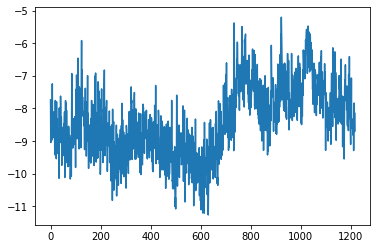

In [5]:
plt.plot(df['WTI'])

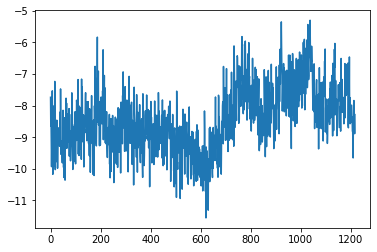

In [6]:
plt.plot(df['GASOLINE'])

# Grid Search for optimal model

In [ ]:
start_date = datetime.datetime(2012, 1, 3)
estimation_length = 220

optimizer_dict = {}
optimizer_dict['no_lag'] = [1, 10]
optimizer_dict['alpha'] = [0.2, 0.4, 0.6, 0.8, 1.0]
optimizer_dict['gamma'] = [0.2, 0.4, 0.6, 0.8, 1.0]

result_dict = {}
result_dict['optimizer_tckr'] = []
result_dict['beta_hat'] = []
result_dict['sigma_hat'] = []
result_dict['loss'] = []

for no_lag in optimizer_dict['no_lag']:
    for alpha in optimizer_dict['alpha']:
        for gamma in optimizer_dict['gamma']:
            _, _, result = main(start_date,estimation_length, no_lag, alpha, gamma, 'gaussian_lasso')
            result_dict['optimizer_tckr'].append('L' + str(no_lag) + '_ALPHA' + str(alpha) + '_GAMMA' + str(gamma))
            result_dict['beta_hat'].append(result['beta_hat'])
            result_dict['sigma_hat'].append(result['sigma_hat'])
            result_dict['loss'].append(result['loss'])

pickle_write('optimization.pickle', result_dict)

# Configuration

In [7]:
est_length = 220
no_lag = 5
alpha = 1
gamma = 0.2
h_step = 5
J = 10
lasso = Lasso()

# Volatility Spillovers

    #######################################################
    ############## End of Window: Oct 28, 2016 ############
    #######################################################

In [49]:
end_rollingwindow = datetime.datetime(2016, 10, 28)
start_index = df[df.DATE == end_rollingwindow].index - est_length - no_lag
est_start = df['DATE'][start_index[0]]
pred_start = df['DATE'][start_index[0] + no_lag]
#### get param
X_tlasso, Y_tlasson, result = main(est_start, est_length, no_lag, alpha, gamma, 't_lasso', None)

#### get hsteps ahead forecasts
forecast_error_dict = {}
forecast_error_dict['DATE'] = []
forecast_error_dict['ERROR'] = []
for i in range(220 - 5):
    pred_start = df['DATE'][start_index[0] + no_lag + i]
    hstep_forecast, sigma_hat = get_hsteps_residual(pred_start, no_lag, result, h_step, J)
    Y_real = df[df['DATE'] >= pred_start].iloc[:h_step, 1:]
    forecast_error = Y_real.reset_index(drop=True) - hstep_forecast.reset_index(drop=True)
    forecast_error_dict['DATE'].append(pred_start)  # df.iloc[i+est_length+no_lag+h_step-1]['DATE'])
    forecast_error_dict['ERROR'].append(forecast_error)

#### volatilities spillover
sigma_hat = pandas.DataFrame(result['sigma_hat'])

vol_spillover = volatilities_spillover()
theta_hat = vol_spillover.get_theta_ma(forecast_error_dict)

vol_spill_dict = {}
vol_spill_dict['j_com'] = []
vol_spill_dict['k_com'] = []
vol_spill_dict['spillover'] = []
for j_com in range(J):
    for k_com in range(J):
        if j_com != k_com:
            vol_spill_dict['j_com'].append(j_com)
            vol_spill_dict['k_com'].append(k_com)
            vol_spill_dict['spillover'].append(vol_spillover.vol_spillover(j_com, k_com, theta_hat, sigma_hat))

spillover = pandas.DataFrame([vol_spill_dict['j_com'], vol_spill_dict['k_com'], vol_spill_dict['spillover']]).transpose()
spillover.columns = ['J_COM', 'K_COM', 'SPILLOVER']
spillover = spillover.set_index(['J_COM', 'K_COM']).unstack()
spillover = pandas.DataFrame(numpy.where(spillover > numpy.nanpercentile(spillover, 85), spillover, numpy.nan))
spillover.columns = [tckr_list[i] for i in range(0, 10)]
spillover.index = [tckr_list[i] for i in range(0, 10)]
sns.heatmap(spillover, cmap='crest')

2.857464849361932
15.96523386495264
9.65366306114467
5.203062148015487
4.401054614719092
2.9019308005186186
2.4550422916383745
1.7822370080522738
1.5091438578102316
1.1484721215538851
0.9709735130476957
0.7610333473352178
0.6420456894110664
0.511731565491548
0.4300676876031915
0.3471318426988681
0.29155753091739456
0.23713031526369832
0.19921890623248117
0.16278784397660928
0.13694229857257412
0.11216594286219994
0.09459542851280567
0.07750862540221704
0.06562316773256427
0.053679079699820775
0.04570474565574223
0.03723512962721287
0.03195580260982567
0.025852254528984986
0.022430754431715272
0.01795188697991179
0.015813289849004875
0.012455935435191634
0.01120567156744201
0.008620960631185781
No. of lags:5 Alpha:1 Gamma:1
2024-01-18 23:12:48.442624
estimate beta_hat done!


TypeError: 'DataFrame' object cannot be interpreted as an integer

    # #######################################################
    # ############## End of Window: Fed, 5, 2015 ###########
    # #######################################################

In [49]:
end_rollingwindow = datetime.datetime(2015, 2, 5)
start_index = df[df.DATE == end_rollingwindow].index - est_length - no_lag
est_start = df['DATE'][start_index[0]]
pred_start = df['DATE'][start_index[0] + no_lag]
#### get param
X_tlasso, Y_tlasson, result = main(est_start, est_length, no_lag, alpha, gamma, 't_lasso', None)

#### get hsteps ahead forecasts
forecast_error_dict = {}
forecast_error_dict['DATE'] = []
forecast_error_dict['ERROR'] = []
for i in range(220 - 5):
    pred_start = df['DATE'][start_index[0] + no_lag + i]
    hstep_forecast, sigma_hat = get_hsteps_residual(pred_start, no_lag, result, h_step, J)
    Y_real = df[df['DATE'] >= pred_start].iloc[:h_step, 1:]
    forecast_error = Y_real.reset_index(drop=True) - hstep_forecast.reset_index(drop=True)
    forecast_error_dict['DATE'].append(pred_start)  # df.iloc[i+est_length+no_lag+h_step-1]['DATE'])
    forecast_error_dict['ERROR'].append(forecast_error)

#### volatilities spillover
sigma_hat = pandas.DataFrame(result['sigma_hat'])

vol_spillover = volatilities_spillover()
theta_hat = vol_spillover.get_theta_ma(forecast_error_dict)

vol_spill_dict = {}
vol_spill_dict['j_com'] = []
vol_spill_dict['k_com'] = []
vol_spill_dict['spillover'] = []
for j_com in range(J):
    for k_com in range(J):
        if j_com != k_com:
            vol_spill_dict['j_com'].append(j_com)
            vol_spill_dict['k_com'].append(k_com)
            vol_spill_dict['spillover'].append(vol_spillover.vol_spillover(j_com, k_com, theta_hat, sigma_hat))

spillover = pandas.DataFrame([vol_spill_dict['j_com'], vol_spill_dict['k_com'], vol_spill_dict['spillover']]).transpose()
spillover.columns = ['J_COM', 'K_COM', 'SPILLOVER']
spillover = spillover.set_index(['J_COM', 'K_COM']).unstack()
spillover = pandas.DataFrame(numpy.where(spillover > numpy.nanpercentile(spillover, 85), spillover, numpy.nan))
spillover.columns = [tckr_list[i] for i in range(0, 10)]
spillover.index = [tckr_list[i] for i in range(0, 10)]
sns.heatmap(spillover, cmap='crest')

2.857464849361932
15.96523386495264
9.65366306114467
5.203062148015487
4.401054614719092
2.9019308005186186
2.4550422916383745
1.7822370080522738
1.5091438578102316
1.1484721215538851
0.9709735130476957
0.7610333473352178
0.6420456894110664
0.511731565491548
0.4300676876031915
0.3471318426988681
0.29155753091739456
0.23713031526369832
0.19921890623248117
0.16278784397660928
0.13694229857257412
0.11216594286219994
0.09459542851280567
0.07750862540221704
0.06562316773256427
0.053679079699820775
0.04570474565574223
0.03723512962721287
0.03195580260982567
0.025852254528984986
0.022430754431715272
0.01795188697991179
0.015813289849004875
0.012455935435191634
0.01120567156744201
0.008620960631185781
No. of lags:5 Alpha:1 Gamma:1
2024-01-18 23:12:48.442624
estimate beta_hat done!


TypeError: 'DataFrame' object cannot be interpreted as an integer

    # #######################################################
    # ############## End of Window: Jun, 17, 2014 ###########
    # #######################################################

In [ ]:
end_rollingwindow = datetime.datetime(2014, 6, 17)
start_index = df[df.DATE == end_rollingwindow].index - est_length - no_lag
est_start = df['DATE'][start_index[0]]
pred_start = df['DATE'][start_index[0] + no_lag]
#### get param
X_tlasso, Y_tlasson, result = main(est_start, est_length, no_lag, alpha, gamma, 't_lasso', None)

#### get hsteps ahead forecasts
forecast_error_dict = {}
forecast_error_dict['DATE'] = []
forecast_error_dict['ERROR'] = []
for i in range(220 - 5):
    pred_start = df['DATE'][start_index[0] + no_lag + i]
    hstep_forecast, sigma_hat = get_hsteps_residual(pred_start, no_lag, result, h_step, J)
    Y_real = df[df['DATE'] >= pred_start].iloc[:h_step, 1:]
    forecast_error = Y_real.reset_index(drop=True) - hstep_forecast.reset_index(drop=True)
    forecast_error_dict['DATE'].append(pred_start)  # df.iloc[i+est_length+no_lag+h_step-1]['DATE'])
    forecast_error_dict['ERROR'].append(forecast_error)

#### volatilities spillover
sigma_hat = pandas.DataFrame(result['sigma_hat'])

vol_spillover = volatilities_spillover()
theta_hat = vol_spillover.get_theta_ma(forecast_error_dict)

vol_spill_dict = {}
vol_spill_dict['j_com'] = []
vol_spill_dict['k_com'] = []
vol_spill_dict['spillover'] = []
for j_com in range(J):
    for k_com in range(J):
        if j_com != k_com:
            vol_spill_dict['j_com'].append(j_com)
            vol_spill_dict['k_com'].append(k_com)
            vol_spill_dict['spillover'].append(vol_spillover.vol_spillover(j_com, k_com, theta_hat, sigma_hat))

spillover = pandas.DataFrame([vol_spill_dict['j_com'], vol_spill_dict['k_com'], vol_spill_dict['spillover']]).transpose()
spillover.columns = ['J_COM', 'K_COM', 'SPILLOVER']
spillover = spillover.set_index(['J_COM', 'K_COM']).unstack()
spillover = pandas.DataFrame(numpy.where(spillover > numpy.nanpercentile(spillover, 85), spillover, numpy.nan))
spillover.columns = [tckr_list[i] for i in range(0, 10)]
spillover.index = [tckr_list[i] for i in range(0, 10)]
sns.heatmap(spillover, cmap='crest')

# Forecast Performance

### MAE of t-lasso

In [ ]:
h_step = 60
ts_length = df.shape[0]
forecast_error_dict = {}
forecast_error_dict['DATE'] = []
forecast_error_dict['ERROR'] = []
#forecast_error_dict['SIGMA'] = []
initparam = None
result = dict()
for i in range(100):#ts_length-est_length - no_lag - h_step):
    est_start = df.DATE[i]
    pred_start = df.DATE[i + est_length + no_lag]
    if est_start.weekday() == 1:
        _, _, result = qmain(est_start, est_length, no_lag, alpha, gamma, 't_lasso', initparam)
    hstep_forecast, sigma_hat = get_hsteps_ahead_forecast(result, pred_start, no_lag, h_step, J)
    Y_real = df[df['DATE'] >= pred_start].iloc[:h_step,1:]
    forecast_error = Y_real.reset_index(drop=True) - hstep_forecast.reset_index(drop=True)
    forecast_error_dict['DATE'].append(pred_start)
    forecast_error_dict['ERROR'].append(forecast_error)
    initparam = numpy.reshape(result['beta_hat'], (-1, J))

    print(i)
    print('----')
    pickle_write('t_lasso_forecast_error.pickle', forecast_error_dict)

## MAE of Gaussian lasso

In [ ]:
h_step = 60
ts_length = df.shape[0]
forecast_error_dict = {}
forecast_error_dict['DATE'] = []
forecast_error_dict['ERROR'] = []
#forecast_error_dict['SIGMA'] = []
initparam = None
result = dict()
for i in range(100):#ts_length-est_length - no_lag - h_step):
    est_start = df.DATE[i]
    pred_start = df.DATE[i + est_length + no_lag]
    if est_start.weekday() == 1:
        _, _, result = qmain(est_start, est_length, no_lag, alpha, gamma, 'gaussian_lasso', initparam)
    hstep_forecast, sigma_hat = get_hsteps_ahead_forecast(result, pred_start, no_lag, h_step, J)
    Y_real = df[df['DATE'] >= pred_start].iloc[:h_step,1:]
    forecast_error = Y_real.reset_index(drop=True) - hstep_forecast.reset_index(drop=True)
    forecast_error_dict['DATE'].append(pred_start)
    forecast_error_dict['ERROR'].append(forecast_error)
    initparam = numpy.reshape(result['beta_hat'], (-1, J))

    print(i)
    print('----')
    pickle_write('g_lasso_forecast_error.pickle', forecast_error_dict)

## Performance Comparision

In [8]:
g=pandas.read_csv('g_error.csv')
t=pandas.read_csv('t_error.csv')

In [9]:
h_step = 1
mae_g1=[]
for i in g['DATE'].unique():
    mae_g1.append(numpy.mean(abs(g[g['DATE'] == i].iloc[h_step-1,:-1])))
mae_t1 = []
for i in t['DATE'].unique():
    mae_t1.append(numpy.mean(abs(t[t['DATE'] == i].iloc[h_step-1,:-1])))

In [10]:
print(numpy.mean(mae_t1))
print(numpy.mean(mae_g1))

0.8642523502461441
0.8809086643352038


In [11]:
# Relative advantage of t-lasso vs Gaussian lasso
ra=0
for i in range(len(mae_t1)):
    if mae_t1[i] < mae_g1[i]:
        ra+=1
print(ra/len(mae_t1))

0.5692307692307692


In [12]:
h_step = 5
mae_g5=[]
for i in g['DATE'].unique():
    mae_g5.append(numpy.mean(abs(g[g['DATE'] == i].iloc[h_step-1,:-1])))
mae_t5 = []
for i in t['DATE'].unique():
    mae_t5.append(numpy.mean(abs(t[t['DATE'] == i].iloc[h_step-1,:-1])))

In [13]:
print(numpy.mean(mae_t5))
print(numpy.mean(mae_g5))

0.9571447249044426
0.9755878406638689


In [14]:
# Relative advantage of t-lasso vs Gaussian lasso
ra=0
for i in range(len(mae_t5)):
    if mae_t5[i] < mae_g5[i]:
        ra+=1
print(ra/len(mae_t5))

0.5897435897435898


In [15]:
h_step = 20
mae_g20=[]
for i in g['DATE'].unique():
    mae_g20.append(numpy.mean(abs(g[g['DATE'] == i].iloc[h_step-1,:-1])))
mae_t20 = []
for i in t['DATE'].unique():
    mae_t20.append(numpy.mean(abs(t[t['DATE'] == i].iloc[h_step-1,:-1])))

In [16]:
print(numpy.mean(mae_t20))
print(numpy.mean(mae_g20))

1.3094528476833787
1.231852395231843


In [17]:
# Relative advantage of t-lasso vs Gaussian lasso
ra=0
for i in range(len(mae_t20)):
    if mae_t20[i] < mae_g20[i]:
        ra+=1
print(ra/len(mae_t20))

0.2964102564102564


In [18]:
h_step = 60
mae_g60=[]
for i in g['DATE'].unique():
    mae_g60.append(numpy.mean(abs(g[g['DATE'] == i].iloc[h_step-1,:-1])))
mae_t60 = []
for i in t['DATE'].unique():
    mae_t60.append(numpy.mean(abs(t[t['DATE'] == i].iloc[h_step-1,:-1])))

In [19]:
print(numpy.mean(mae_t60))
print(numpy.mean(mae_g60))

2.632955526589275
2.2168260582346977


In [20]:
# Relative advantage of t-lasso vs Gaussian lasso
ra=0
for i in range(len(mae_t60)):
    if mae_t60[i] < mae_g60[i]:
        ra+=1
print(ra/len(mae_t60))

0.050256410256410255


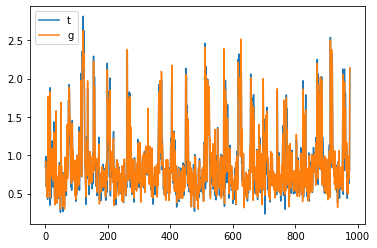

In [21]:
plt.plot(mae_t1, label ='t')
plt.plot(mae_g1, label ='g')
plt.legend()

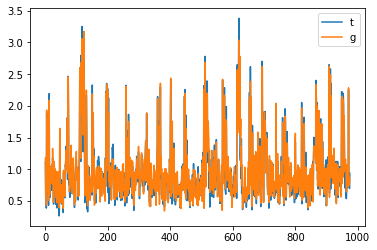

In [22]:
plt.plot(mae_t5, label ='t')
plt.plot(mae_g5, label ='g')
plt.legend()

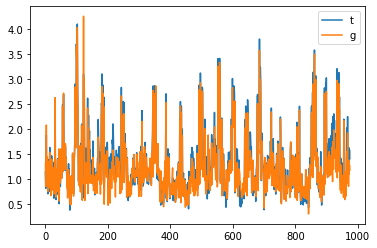

In [23]:
plt.plot(mae_t20, label ='t')
plt.plot(mae_g20, label ='g')
plt.legend()

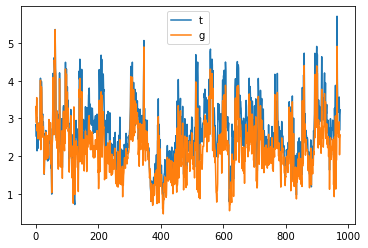

In [24]:
plt.plot(mae_t60, label ='t')
plt.plot(mae_g60, label ='g')
plt.legend()

In [68]:
numpy.cov(mae_t60)

array(0.61232655)

In [67]:
numpy.cov(mae_g60)

array(0.54697163)